# Augmentations

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

sys.path.append('../')

import numpy as np
import pandas as pd
import tensorflow as tf

from src.data import MRISequence

In [2]:
import matplotlib.pyplot as plt


def plot_images(dataset, n_images, samples_per_image, input_shape):
    output = np.zeros((input_shape[1] * n_images, input_shape[2] * samples_per_image))

    row = 0
    for images, _ in dataset.repeat(samples_per_image).batch(n_images):
        images = np.vstack(images.numpy()[:, 56, :, :, :])
        output[:, row*input_shape[2]:(row + 1) * input_shape[2]] = images.reshape(images.shape[:-1])
        row += 1

    plt.figure(figsize=(20, 20))
    plt.imshow(output)
    plt.show()

Load dataset...

In [3]:
batch_size = 32

input_shape = (104, 128, 104, 1) # (112, 112, 105, 1)
resize_img = True
crop_img = True

desc = {'mean': -3.6344006e-09, 'std': 1.0000092, 'min': -1.4982183, 'max': 10.744175}
normalization={ 'type':'normalization', 'desc': desc }

seq = MRISequence(
    '../tmp/data-v3/test',
    batch_size,
    input_shape=input_shape,
    class_names=['AD', 'CN'],
    resize_img=resize_img,
    normalization=normalization,
    crop_img=crop_img,
    one_hot=True)

In [4]:
val_x = None
val_y = None

for batch_x, batch_y in seq:
    val_x = batch_x
    val_y = batch_y
    break

## Augmentations

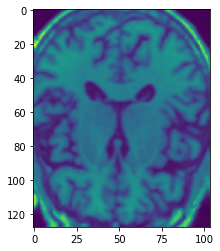

In [5]:
import matplotlib.pyplot as plt

x = val_x[0]
rotated = tf.keras.preprocessing.image.random_rotation(
    x.reshape(x.shape[:-1]),
    2.5,
    row_axis=1,
    col_axis=2,
    channel_axis=0,
    fill_mode='nearest',
    cval=0.0,
    interpolation_order=1
)

plt.imshow(rotated[56])

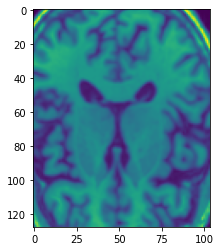

In [130]:
x = val_x[0]
zoom = 0.25

x_zoomed = tf.keras.preprocessing.image.random_zoom(
    x.reshape(x.shape[:3]),
    (1 - zoom, 1),
    row_axis=1,
    col_axis=2,
    channel_axis=0,
    fill_mode='nearest',
    cval=0.0,
    interpolation_order=1
)

plt.imshow(x_zoomed[56])

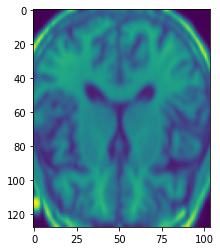

In [7]:
from skimage import filters

x = val_x[0]
x = np.array(x.reshape(x.shape[:3]))

plt.imshow(filters.gaussian(x, multichannel=True, sigma=1.5)[56])

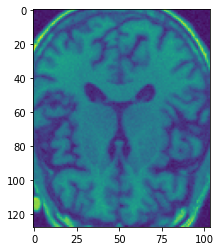

In [8]:
from skimage.util import random_noise

seed = None if 'RANDOM_SEED' not in globals() else globals()['RANDOM_SEED']
var = tf.random.uniform([], 0, 1) * 0.0005
x = random_noise(batch_x[0], mode='gaussian', seed=None, var=var, clip=True)

plt.imshow(x[56])

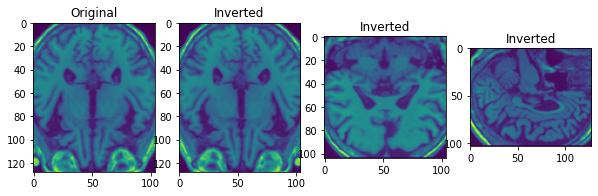

In [9]:
def show_img(a):
    return a.reshape(a.shape[:-1])

img = batch_x[0]
x = img[:, :, ::-1, :]

fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(10, 10))
ax = axes.ravel()

ax[0].set_title('Original')
ax[0].imshow(show_img(img[50]))

ax[1].set_title('Inverted')
ax[1].imshow(show_img(x[50, :, :, :]))

ax[2].set_title('Inverted')
ax[2].imshow(show_img(x[:, 50, :, :]))

ax[3].set_title('Inverted')
ax[3].imshow(show_img(x[:, :, 50, :]))

## augment(x)

In [31]:
import tensorflow as tf
import numpy as np

from skimage import filters
from skimage.util import random_noise


def augment_invert_img(x):
    return x[:, :, ::-1, :]


def augment_rotate_img(x, angle=None):
    x_rotated = tf.keras.preprocessing.image.random_rotation(
        x.reshape(x.shape[:3]),
        angle,
        row_axis=1,
        col_axis=2,
        channel_axis=0,
        fill_mode='nearest',
        cval=0.0,
        interpolation_order=1
    )
    return x_rotated.reshape((*x_rotated.shape, 1))


def augment_random_zoom(x, zoom=None):
    x_zoomed = tf.keras.preprocessing.image.random_zoom(
        x.reshape(x.shape[:3]),
        (1 - zoom, 1),
        row_axis=1,
        col_axis=2,
        channel_axis=0,
        fill_mode='constant',
        cval=0.0,
        interpolation_order=1
    )
    return x_zoomed.reshape((*x_zoomed.shape, 1))


def augment_random_shear(x, angle=None):
    x_shared = tf.keras.preprocessing.image.random_shear(
        x.reshape(x.shape[:3]), angle, row_axis=1, col_axis=2, channel_axis=0, fill_mode='nearest',
        cval=0.0, interpolation_order=1
    )
    return x_shared.reshape((*x_shared.shape, 1))


def augment_random_gaussian_blur(x, sigma=None):
    x = np.array(x.reshape(x.shape[:3]))
    return filters.gaussian(x, multichannel=True, sigma=sigma).reshape((*x.shape, 1))


def augment_random_gaussian_noise(x, var=None):
    x = np.array(x.reshape(x.shape[:3]))
    seed = None if 'RANDOM_SEED' not in globals() else globals()['RANDOM_SEED']
    var = tf.random.uniform([], 0, 1) * var
    x = random_noise(x, mode='gaussian', seed=None, var=var, clip=True)
    return x.reshape((*x.shape, 1))


def augment(x):
    x = x.numpy()

    if tf.random.uniform([], 0, 1) < 0.5:
        x = augment_invert_img(x)

    if tf.random.uniform([], 0, 1) < 0.15:
        x = augment_rotate_img(x, angle=5)

    if tf.random.uniform([], 0, 1) < 0.15:
        x = augment_random_zoom(x, zoom=0.015)

#     if tf.random.uniform([], 0, 1) < 0.15:
#         x = augment_random_shear(x, angle=2.5)

    if tf.random.uniform([], 0, 1) < 0.15:
        x = augment_random_gaussian_blur(x, sigma=0.8)
    
    if tf.random.uniform([], 0, 1) < 0.15:
        x = augment_random_gaussian_noise(x, var=0.00025)

    return x

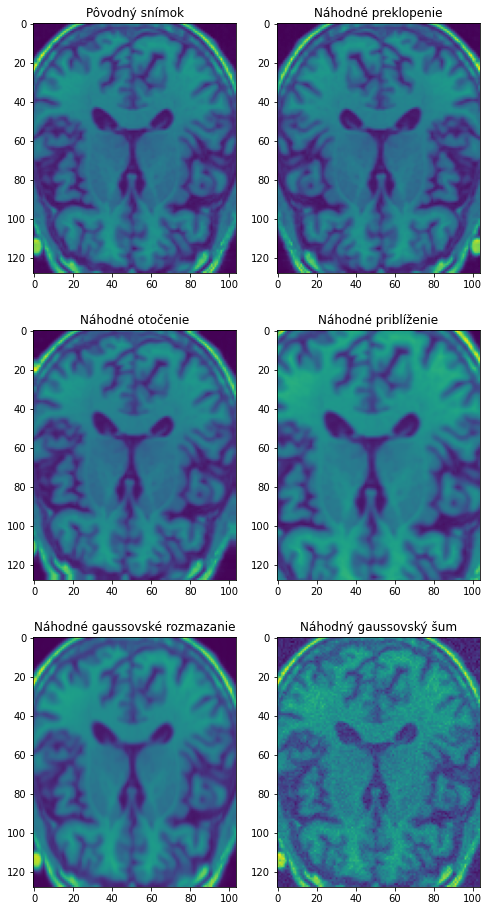

In [139]:
plt.figure(figsize=(8, 16))

r = 3
c = 2

plt.subplot(r, c, 1)
plt.title('Pôvodný snímok')
plt.imshow(x[56])

plt.subplot(r, c, 2)
plt.title('Náhodné preklopenie')
plt.imshow(augment_invert_img(x)[56])

plt.subplot(r, c, 3)
plt.title('Náhodné otočenie')
plt.imshow(augment_rotate_img(x, angle=5)[56])

plt.subplot(r, c, 4)
plt.title('Náhodné priblíženie')
plt.imshow(augment_random_zoom(x, zoom=0.15)[56])

plt.subplot(r, c, 5)
plt.title('Náhodné gaussovské rozmazanie')
plt.imshow(augment_random_gaussian_blur(x, sigma=0.8)[56])

plt.subplot(r, c, 6)
plt.title('Náhodný gaussovský šum')
plt.imshow(augment_random_gaussian_noise(x, var=0.00025)[56])

In [11]:
# def augment(x):
#     x = x.numpy()

#     x = augment_invert_img(x)
#     x = augment_rotate_img(x, angle=10)
#     x = augment_random_zoom(x, zoom=0.05)
# #     x = augment_random_shear(x, angle=2.5)
#     x = augment_random_gaussian_blur(x, sigma=1.5)
#     x = augment_random_gaussian_noise(x, var=0.0004)

#     return x

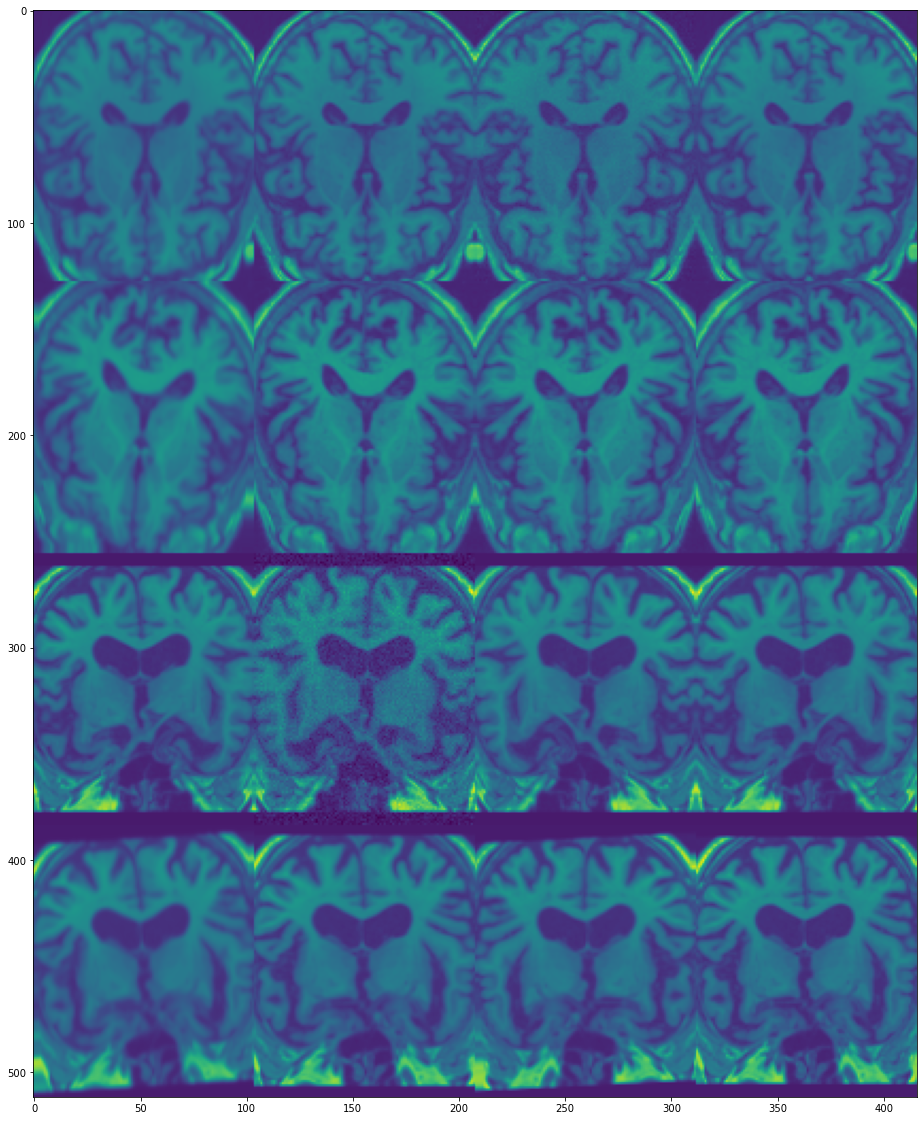

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE


i = 4
dataset = tf.data.Dataset.from_tensor_slices((val_x[:i], val_y[:i]))
dataset = dataset.map(lambda x, y: (tf.py_function(func=augment, inp=[x], Tout=tf.float32), y), num_parallel_calls=AUTOTUNE)

plot_images(dataset, i, i, input_shape)